# Klasifikasi Kinerja Prosesor Smartphone
## Prediksi Kelas Performa HP (Gaming vs Entry Level)

**Tujuan:** Mengelompokkan HP berdasarkan jumlah core prosesor, kecepatan clock, dan RAM untuk membantu orang awam memahami apakah HP termasuk kelas "Gaming" atau "Harian".

**Algoritma:** Random Forest Classifier

## 1. Import Library

In [29]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import StandardScaler

# Model persistence
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Dataset

In [30]:
# Load data
df = pd.read_csv('dataset/train.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (2000, 21)

First 5 rows:


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## 3. Exploratory Data Analysis (EDA)

In [31]:
# Dataset info
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [32]:
# Check missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nTotal Missing:", df.isnull().sum().sum())

Missing Values:
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Total Missing: 0


Distribusi Price Range:
price_range
0    500
1    500
2    500
3    500
Name: count, dtype: int64

Persentase:
price_range
0    25.0
1    25.0
2    25.0
3    25.0
Name: proportion, dtype: float64


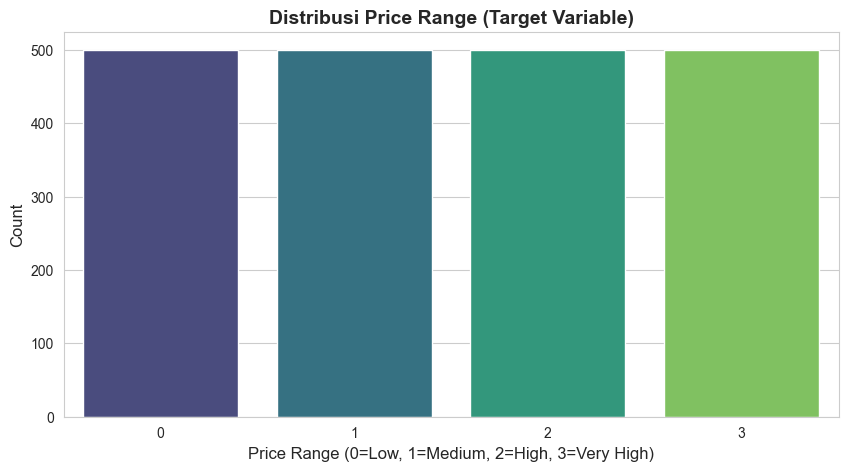

In [33]:
# Distribusi target variable (price_range)
print("Distribusi Price Range:")
print(df['price_range'].value_counts().sort_index())
print("\nPersentase:")
print(df['price_range'].value_counts(normalize=True).sort_index() * 100)

# Visualisasi
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='price_range', palette='viridis')
plt.title('Distribusi Price Range (Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel('Price Range (0=Low, 1=Medium, 2=High, 3=Very High)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### 3.1 Analisis Fitur Utama (Processor Cores, Clock Speed, RAM)

In [34]:
# Fokus pada fitur internal yang relevan
key_features = ['n_cores', 'clock_speed', 'ram', 'price_range']

print("Statistik Fitur Utama:")
print(df[key_features].describe())

Statistik Fitur Utama:
           n_cores  clock_speed          ram  price_range
count  2000.000000  2000.000000  2000.000000  2000.000000
mean      4.520500     1.522250  2124.213000     1.500000
std       2.287837     0.816004  1084.732044     1.118314
min       1.000000     0.500000   256.000000     0.000000
25%       3.000000     0.700000  1207.500000     0.750000
50%       4.000000     1.500000  2146.500000     1.500000
75%       7.000000     2.200000  3064.500000     2.250000
max       8.000000     3.000000  3998.000000     3.000000


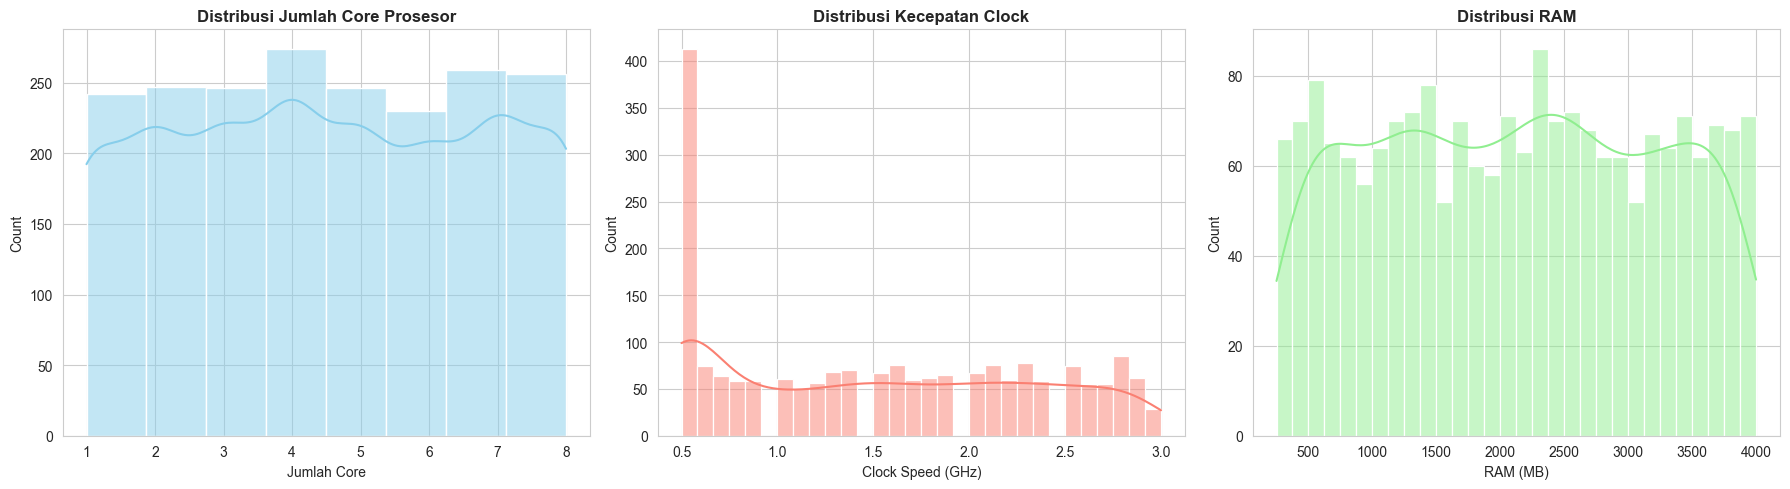

In [35]:
# Visualisasi distribusi fitur utama
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Number of cores
sns.histplot(data=df, x='n_cores', bins=8, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribusi Jumlah Core Prosesor', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Jumlah Core')

# Clock speed
sns.histplot(data=df, x='clock_speed', bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribusi Kecepatan Clock', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Clock Speed (GHz)')

# RAM
sns.histplot(data=df, x='ram', bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribusi RAM', fontsize=12, fontweight='bold')
axes[2].set_xlabel('RAM (MB)')

plt.tight_layout()
plt.show()

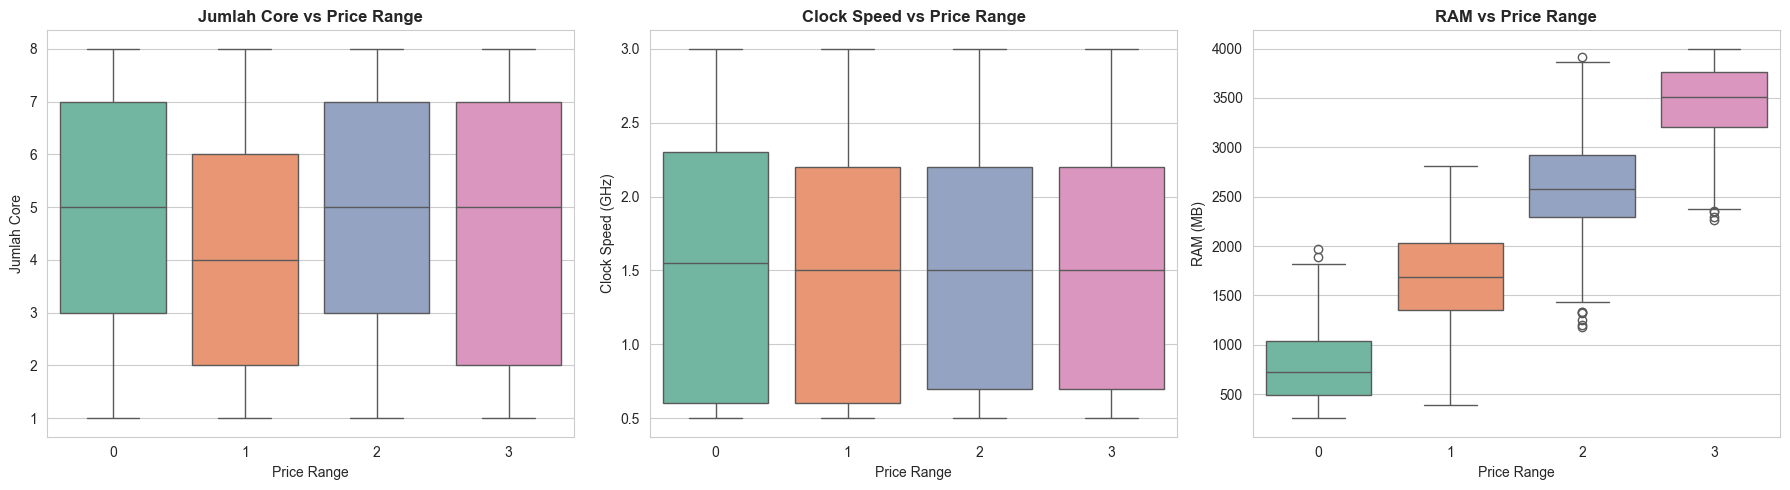

In [36]:
# Hubungan fitur utama dengan price_range
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cores vs Price Range
sns.boxplot(data=df, x='price_range', y='n_cores', ax=axes[0], palette='Set2')
axes[0].set_title('Jumlah Core vs Price Range', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Price Range')
axes[0].set_ylabel('Jumlah Core')

# Clock Speed vs Price Range
sns.boxplot(data=df, x='price_range', y='clock_speed', ax=axes[1], palette='Set2')
axes[1].set_title('Clock Speed vs Price Range', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Price Range')
axes[1].set_ylabel('Clock Speed (GHz)')

# RAM vs Price Range
sns.boxplot(data=df, x='price_range', y='ram', ax=axes[2], palette='Set2')
axes[2].set_title('RAM vs Price Range', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Price Range')
axes[2].set_ylabel('RAM (MB)')

plt.tight_layout()
plt.show()

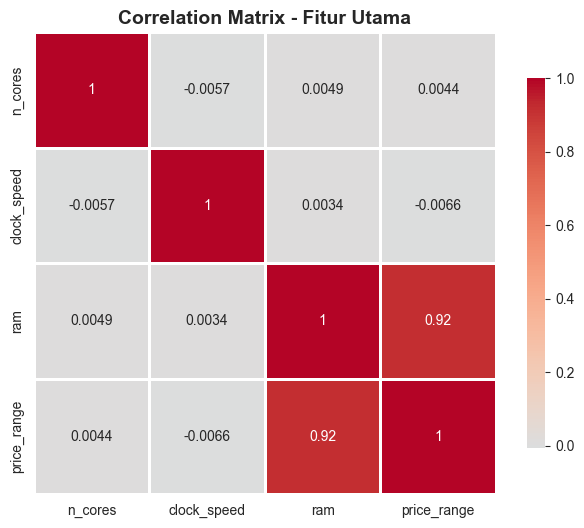


Korelasi dengan Price Range:
price_range    1.000000
ram            0.917046
n_cores        0.004399
clock_speed   -0.006606
Name: price_range, dtype: float64


In [37]:
# Correlation matrix untuk fitur utama
plt.figure(figsize=(8, 6))
correlation = df[key_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Fitur Utama', fontsize=14, fontweight='bold')
plt.show()

print("\nKorelasi dengan Price Range:")
print(correlation['price_range'].sort_values(ascending=False))

## 4. Data Preprocessing

In [38]:
# Pilih fitur yang akan digunakan
# Fokus pada fitur internal: processor cores, clock speed, RAM, dan fitur hardware lainnya
selected_features = [
    'battery_power',  # Daya baterai (mAh)
    'clock_speed',    # Kecepatan clock prosesor (GHz)
    'n_cores',        # Jumlah core prosesor
    'ram',            # RAM (MB)
    'int_memory',     # Internal memory (GB)
    'mobile_wt',      # Berat HP
    'pc',             # Primary camera megapixels
    'fc',             # Front camera megapixels
    'px_height',      # Pixel resolution height
    'px_width'        # Pixel resolution width
]

# Prepare features and target
X = df[selected_features]
y = df['price_range']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nSelected Features:")
print(X.columns.tolist())

Features shape: (2000, 10)
Target shape: (2000,)

Selected Features:
['battery_power', 'clock_speed', 'n_cores', 'ram', 'int_memory', 'mobile_wt', 'pc', 'fc', 'px_height', 'px_width']


In [39]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("\nTarget distribution in training set:")
print(y_train.value_counts().sort_index())
print("\nTarget distribution in testing set:")
print(y_test.value_counts().sort_index())

Training set size: (1600, 10)
Testing set size: (400, 10)

Target distribution in training set:
price_range
0    400
1    400
2    400
3    400
Name: count, dtype: int64

Target distribution in testing set:
price_range
0    100
1    100
2    100
3    100
Name: count, dtype: int64


In [40]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled training data shape:", X_train_scaled.shape)
print("Scaled testing data shape:", X_test_scaled.shape)


Scaled training data shape: (1600, 10)
Scaled testing data shape: (400, 10)


## 5. Model Training - Random Forest

### 5.1 Baseline Model

In [41]:
# Train baseline Random Forest model
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_scaled, y_train)

# Predictions
y_pred_baseline = rf_baseline.predict(X_test_scaled)

# Evaluate
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

print(f"\nAccuracy: {accuracy_baseline:.4f} ({accuracy_baseline*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Low (0)', 'Medium (1)', 'High (2)', 'Very High (3)']))


Accuracy: 0.9150 (91.50%)

Classification Report:
               precision    recall  f1-score   support

      Low (0)       0.96      0.96      0.96       100
   Medium (1)       0.88      0.86      0.87       100
     High (2)       0.86      0.89      0.87       100
Very High (3)       0.97      0.95      0.96       100

     accuracy                           0.92       400
    macro avg       0.92      0.92      0.92       400
 weighted avg       0.92      0.92      0.92       400



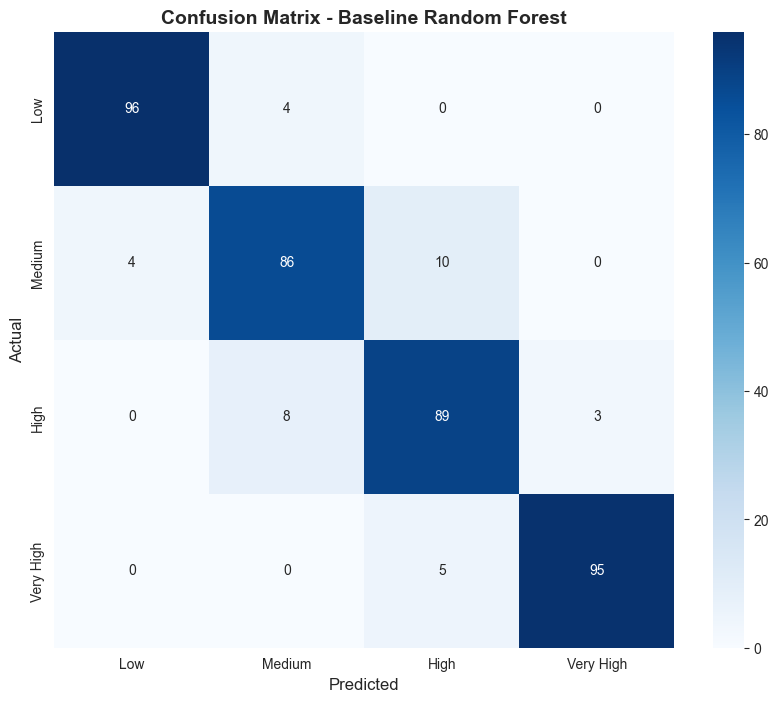

In [42]:
# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.title('Confusion Matrix - Baseline Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

### 5.2 Hyperparameter Tuning

In [43]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Starting GridSearchCV...")
print("This may take a few minutes...\n")

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV...
This may take a few minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.8900


### 5.3 Final Model with Best Parameters

In [44]:
# Train final model with best parameters
rf_final = grid_search.best_estimator_

# Predictions
y_pred_final = rf_final.predict(X_test_scaled)

# Evaluate
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final, average='weighted')
recall_final = recall_score(y_test, y_pred_final, average='weighted')
f1_final = f1_score(y_test, y_pred_final, average='weighted')

print(f"\nAccuracy:  {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"Precision: {precision_final:.4f}")
print(f"Recall:    {recall_final:.4f}")
print(f"F1-Score:  {f1_final:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final,
                          target_names=['Low (0)', 'Medium (1)', 'High (2)', 'Very High (3)']))


Accuracy:  0.9125 (91.25%)
Precision: 0.9131
Recall:    0.9125
F1-Score:  0.9125

Classification Report:
               precision    recall  f1-score   support

      Low (0)       0.95      0.97      0.96       100
   Medium (1)       0.89      0.85      0.87       100
     High (2)       0.85      0.89      0.87       100
Very High (3)       0.96      0.94      0.95       100

     accuracy                           0.91       400
    macro avg       0.91      0.91      0.91       400
 weighted avg       0.91      0.91      0.91       400



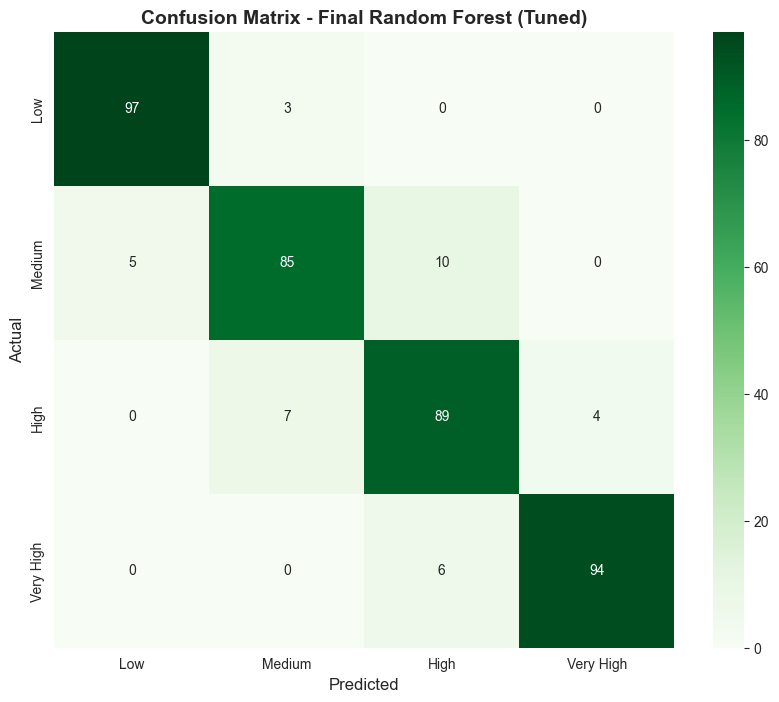

In [45]:
# Confusion Matrix for final model
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.title('Confusion Matrix - Final Random Forest (Tuned)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

### 5.4 Feature Importance

Feature Importance:
         feature  importance
3            ram    0.630450
0  battery_power    0.087111
9       px_width    0.063088
8      px_height    0.061300
5      mobile_wt    0.036935
4     int_memory    0.033179
6             pc    0.024897
1    clock_speed    0.022660
7             fc    0.020822
2        n_cores    0.019558


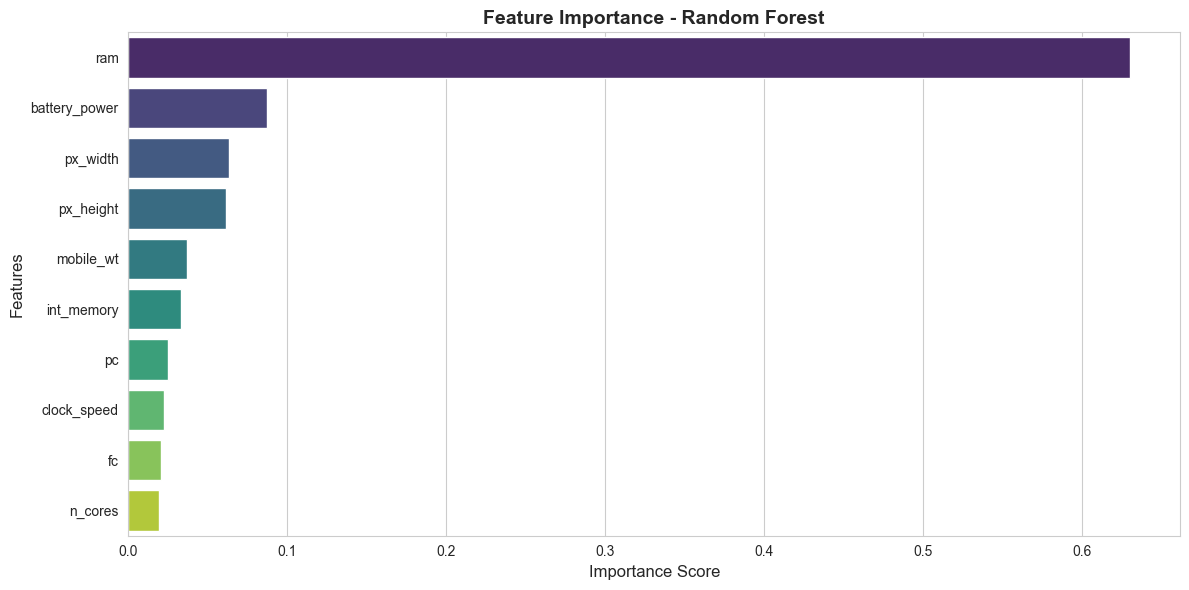

In [46]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Model Comparison

      Model  Accuracy  Precision  Recall  F1-Score
Baseline RF    0.9150   0.915677  0.9150  0.915208
   Tuned RF    0.9125   0.913130  0.9125  0.912495


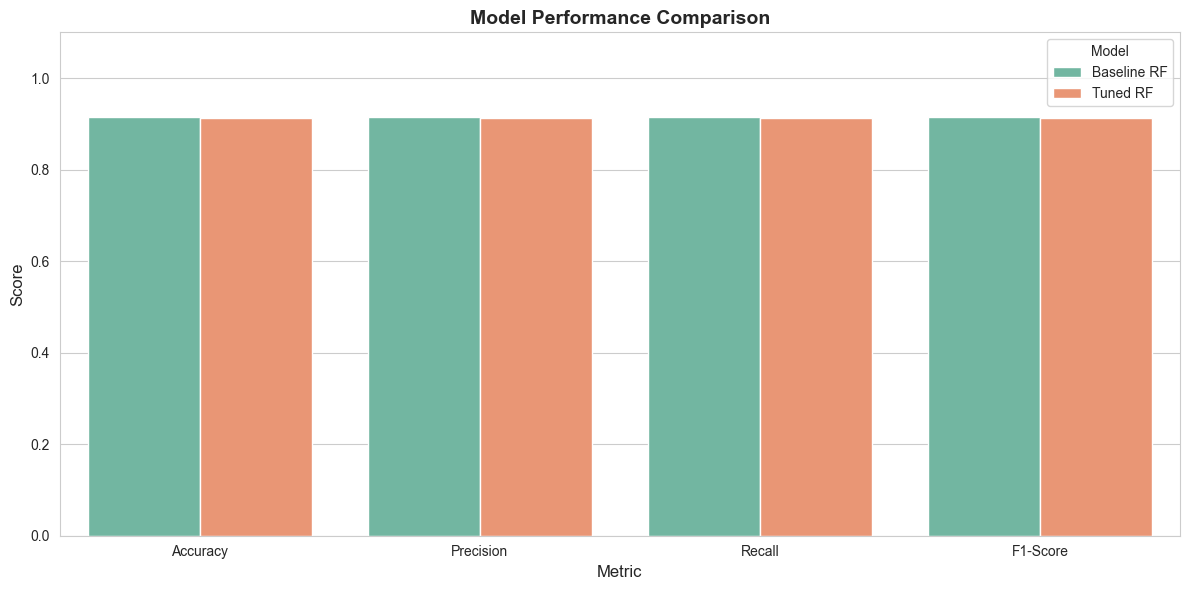

In [47]:
# Compare baseline vs tuned model
comparison = pd.DataFrame({
    'Model': ['Baseline RF', 'Tuned RF'],
    'Accuracy': [accuracy_baseline, accuracy_final],
    'Precision': [
        precision_score(y_test, y_pred_baseline, average='weighted'),
        precision_final
    ],
    'Recall': [
        recall_score(y_test, y_pred_baseline, average='weighted'),
        recall_final
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_baseline, average='weighted'),
        f1_final
    ]
})

print(comparison.to_string(index=False))

# Visualize comparison
comparison_melted = comparison.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## 7. Cross-Validation


Cross-Validation Scores: [0.8625  0.90625 0.90625 0.88125 0.9125  0.9     0.875   0.89375 0.8875
 0.9    ]

Mean CV Score: 0.8925 (+/- 0.0300)
Min CV Score:  0.8625
Max CV Score:  0.9125


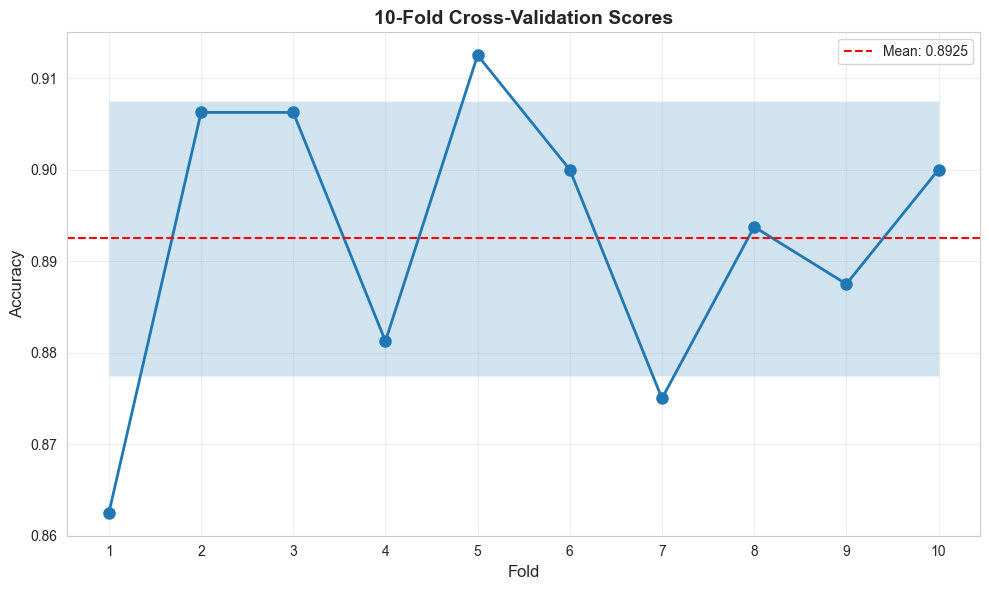

In [48]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(rf_final, X_train_scaled, y_train, cv=10, scoring='accuracy')

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"\nMean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Min CV Score:  {cv_scores.min():.4f}")
print(f"Max CV Score:  {cv_scores.max():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2)
plt.title('10-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Prediction Examples

In [49]:
# Mapping untuk interpretasi hasil
price_range_mapping = {
    0: 'Entry Level (Harian)',
    1: 'Mid Range (Harian+)',
    2: 'High End (Gaming)',
    3: 'Flagship (Gaming Pro)'
}

# Ambil beberapa sample dari test set
sample_indices = [0, 50, 100, 150, 200]

for idx in sample_indices:
    sample = X_test.iloc[idx:idx+1]
    sample_scaled = scaler.transform(sample)
    prediction = rf_final.predict(sample_scaled)[0]
    actual = y_test.iloc[idx]
    
    print(f"\nSample {idx+1}:")
    print(f"  Cores: {sample['n_cores'].values[0]}")
    print(f"  Clock Speed: {sample['clock_speed'].values[0]} GHz")
    print(f"  RAM: {sample['ram'].values[0]} MB")
    print(f"  Prediksi: {price_range_mapping[prediction]}")
    print(f"  Aktual: {price_range_mapping[actual]}")
    print(f"  Status: {'✓ BENAR' if prediction == actual else '✗ SALAH'}")
    print("-" * 50)


Sample 1:
  Cores: 6
  Clock Speed: 2.5 GHz
  RAM: 3566 MB
  Prediksi: Flagship (Gaming Pro)
  Aktual: Flagship (Gaming Pro)
  Status: ✓ BENAR
--------------------------------------------------

Sample 51:
  Cores: 2
  Clock Speed: 0.5 GHz
  RAM: 588 MB
  Prediksi: Entry Level (Harian)
  Aktual: Entry Level (Harian)
  Status: ✓ BENAR
--------------------------------------------------

Sample 101:
  Cores: 1
  Clock Speed: 3.0 GHz
  RAM: 3851 MB
  Prediksi: Flagship (Gaming Pro)
  Aktual: Flagship (Gaming Pro)
  Status: ✓ BENAR
--------------------------------------------------

Sample 151:
  Cores: 2
  Clock Speed: 2.4 GHz
  RAM: 3971 MB
  Prediksi: Flagship (Gaming Pro)
  Aktual: Flagship (Gaming Pro)
  Status: ✓ BENAR
--------------------------------------------------

Sample 201:
  Cores: 4
  Clock Speed: 0.6 GHz
  RAM: 1998 MB
  Prediksi: Mid Range (Harian+)
  Aktual: Mid Range (Harian+)
  Status: ✓ BENAR
--------------------------------------------------


## 9. Save Model

In [50]:
# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the final model using joblib (recommended for sklearn models)
joblib.dump(rf_final, 'models/smartphone_performance_rf_model.pkl')
print("✓ Model saved as: models/smartphone_performance_rf_model.pkl")

# Save the scaler
joblib.dump(scaler, 'models/smartphone_performance_scaler.pkl')
print("✓ Scaler saved as: models/smartphone_performance_scaler.pkl")

# Save feature names
joblib.dump(selected_features, 'models/smartphone_performance_features.pkl')
print("✓ Feature names saved as: models/smartphone_performance_features.pkl")

# Alternative: Save using pickle
with open('models/smartphone_performance_rf_model_pickle.pkl', 'wb') as f:
    pickle.dump(rf_final, f)
print("✓ Model saved using pickle: models/smartphone_performance_rf_model_pickle.pkl")


✓ Model saved as: models/smartphone_performance_rf_model.pkl
✓ Scaler saved as: models/smartphone_performance_scaler.pkl
✓ Feature names saved as: models/smartphone_performance_features.pkl
✓ Model saved using pickle: models/smartphone_performance_rf_model_pickle.pkl


## 10. Load and Test Saved Model

In [51]:
# Load the saved model
loaded_model = joblib.load('models/smartphone_performance_rf_model.pkl')
loaded_scaler = joblib.load('models/smartphone_performance_scaler.pkl')
loaded_features = joblib.load('models/smartphone_performance_features.pkl')

print("✓ Model loaded successfully!")
print(f"✓ Scaler loaded successfully!")
print(f"✓ Features loaded: {loaded_features}")

# Test the loaded model
test_sample = X_test.iloc[0:1]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_prediction = loaded_model.predict(test_sample_scaled)[0]

print("\n" + "="*60)
print("LOADED MODEL")
print("="*60)
print(f"\nTest Sample Features:")
for feature in loaded_features:
    print(f"  {feature}: {test_sample[feature].values[0]}")
print(f"\nPrediction: {price_range_mapping[test_prediction]}")
print(f"Actual: {price_range_mapping[y_test.iloc[0]]}")

✓ Model loaded successfully!
✓ Scaler loaded successfully!
✓ Features loaded: ['battery_power', 'clock_speed', 'n_cores', 'ram', 'int_memory', 'mobile_wt', 'pc', 'fc', 'px_height', 'px_width']

LOADED MODEL

Test Sample Features:
  battery_power: 1773
  clock_speed: 2.5
  n_cores: 6
  ram: 3566
  int_memory: 32
  mobile_wt: 170
  pc: 18
  fc: 16
  px_height: 1215
  px_width: 1472

Prediction: Flagship (Gaming Pro)
Actual: Flagship (Gaming Pro)


## 11. Summary

In [52]:
print(f"\nDataset: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nTarget: Price Range (4 classes)")
print(f"   - 0: Entry Level (Harian)")
print(f"   - 1: Mid Range (Harian+)")
print(f"   - 2: High End (Gaming)")
print(f"   - 3: Flagship (Gaming Pro)")
print(f"\nFeatures Used: {len(selected_features)} features")
print(f"   Key features: n_cores, clock_speed, ram")
print(f"\n Algorithm: Random Forest Classifier")
print(f"   Best Parameters: {grid_search.best_params_}")
print(f"\nPerformance:")
print(f"   - Accuracy: {accuracy_final:.4f} ({accuracy_final*100:.2f}%)")
print(f"   - Precision: {precision_final:.4f}")
print(f"   - Recall: {recall_final:.4f}")
print(f"   - F1-Score: {f1_final:.4f}")
print(f"   - CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\nSaved Models:")
print(f"   - models/smartphone_performance_rf_model.pkl")
print(f"   - models/smartphone_performance_scaler.pkl")
print(f"   - models/smartphone_performance_features.pkl")


Dataset: 2000 samples, 21 features

Target: Price Range (4 classes)
   - 0: Entry Level (Harian)
   - 1: Mid Range (Harian+)
   - 2: High End (Gaming)
   - 3: Flagship (Gaming Pro)

Features Used: 10 features
   Key features: n_cores, clock_speed, ram

 Algorithm: Random Forest Classifier
   Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Performance:
   - Accuracy: 0.9125 (91.25%)
   - Precision: 0.9131
   - Recall: 0.9125
   - F1-Score: 0.9125
   - CV Score: 0.8925 (+/- 0.0300)

Saved Models:
   - models/smartphone_performance_rf_model.pkl
   - models/smartphone_performance_scaler.pkl
   - models/smartphone_performance_features.pkl
